In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt


In [7]:
def getTestData():
    images = []
    for i in range(1, 4):
        images.append(cv.imread(f"img/test/test0{i}.jpg"))

    return images


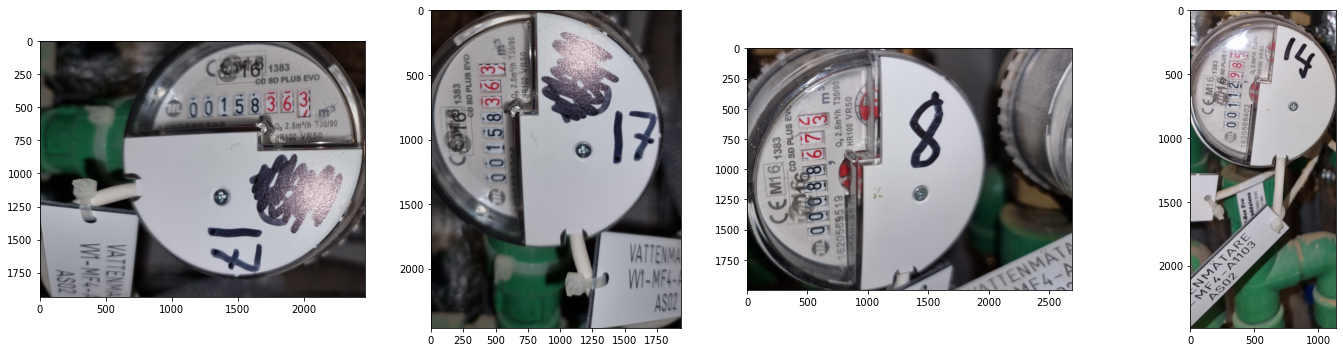

In [16]:
aliend = cv.imread("Aligned.jpg")
test_imgs = getTestData()

fig, ax = plt.subplots(1, 4)
fig.set_tight_layout("tight")
fig.set_size_inches(20, 5)
_ = ax[0].imshow(aliend[:, :, ::-1])
_ = ax[1].imshow(test_imgs[0][:, :, ::-1])
_ = ax[2].imshow(test_imgs[1][:, :, ::-1])
_ = ax[3].imshow(test_imgs[2][:, :, ::-1])


In [64]:
def get_matches(aliend, test_img):
    g_aliend = cv.cvtColor(aliend, cv.COLOR_BGR2GRAY)
    g_test = cv.cvtColor(test_img, cv.COLOR_BGR2GRAY)

    orb = cv.ORB_create(500)
    keypoints_aliend, descriptors1 = orb.detectAndCompute(g_aliend, None)
    keypoints_test_img, descriptors2 = orb.detectAndCompute(g_test, None)
    matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

    matches = matcher.match(descriptors1, descriptors2, None)

    matches = sorted(matches, key=lambda x: x.distance)

    return keypoints_aliend, keypoints_test_img, matches[:int(len(matches) * 0.15)]


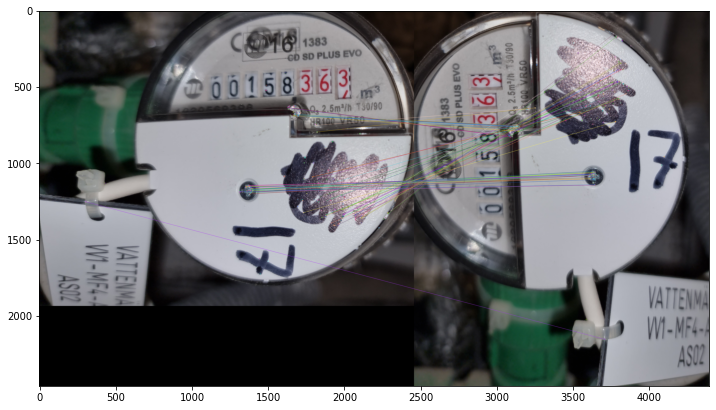

In [73]:
ix = 0
kp_alined, kp_test, matches =get_matches(aliend, test_imgs[ix])
imMatches = cv.drawMatches(aliend, kp_alined, test_imgs[ix], kp_test, matches, None)

fig, ax = plt.subplots()
fig.set_size_inches(12,24)
_ = ax.imshow(imMatches[:,:,::-1])

In [96]:
ix = 0
kp_alined, kp_test, matches = get_matches(aliend, test_imgs[ix])

points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = kp_alined[match.queryIdx].pt
    points2[i, :] = kp_test[match.queryIdx].pt


h, mask = cv.findHomography(points1, points2, cv.RANSAC)
height, width, channels = test_imgs[ix].shape
im1Reg = cv.warpPerspective(aliend, h, (width, height))



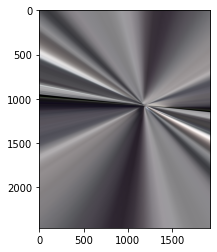

In [97]:
plt.imshow(im1Reg)

In [110]:

MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

def alignImages(im1, im2):

  # Convert images to grayscale
  im1Gray = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)
  im2Gray = cv.cvtColor(im2, cv.COLOR_BGR2GRAY)

  # Detect ORB features and compute descriptors.
  orb = cv.ORB_create(MAX_FEATURES)
  keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

  # Match features.
  matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matches = matcher.match(descriptors1, descriptors2, None)

  # Sort matches by score
  # matches.sort(key=lambda x: x.distance, reverse=False)
  matches = sorted(matches, key=lambda x: x.distance, reverse=True)

  # Remove not so good matches
  numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:numGoodMatches]

  # Draw top matches
  # imMatches = cv.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
  # cv.imwrite("matches.jpg", imMatches)

  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)

  for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

  # Find homography
  h, mask = cv.findHomography(points1, points2, cv.RANSAC)

  # Use homography
  height, width, channels = im2.shape
  im1Reg = cv.warpPerspective(im1, h, (width, height))

  return im1Reg, h

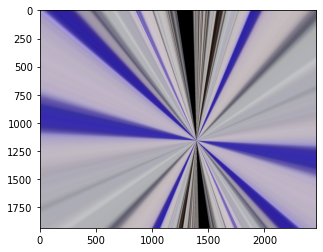

In [112]:
imReg, h = alignImages(test_imgs[1], aliend)
plt.imshow(imReg)


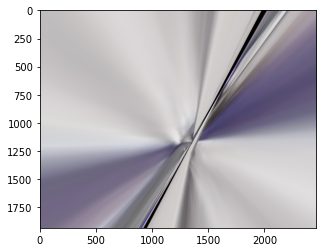